Initial test of Avito dataset. Used the following features:
1. parentCategoryID_x
2. price_diff : Log of the absolute difference in prices between itemID_1 and itemID_2.
3. title_desc_xy : Title and description of itemID_1 and itemID_2 concatenated together.

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.similarities.docsim import Similarity
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from gensim.models import Word2Vec, Doc2Vec
from bs4 import BeautifulSoup
import re
import nltk.data
import string
from gensim.models.doc2vec import TaggedDocument
from gensim import matutils

In [12]:
iteminfo_train = pd.read_csv('ItemInfo_train.csv')
#iteminfo_test = pd.read_csv('ItemInfo_test.csv')

In [13]:
itempairs_train = pd.read_csv('ItemPairs_train.csv')
#itempairs_test = pd.read_csv('ItemPairs_test.csv')

In [14]:
location = pd.read_csv('Location.csv')
category = pd.read_csv('Category.csv')

In [15]:
print 'Length of ItemPairs_train.csv ' + str(len(itempairs_train))
print 'Length of ItemInfo_train.csv ' + str(len(iteminfo_train))
print 'Length of Location.csv ' + str(len(location))
print 'Length of Category.csv ' + str(len(category))

Length of ItemPairs_train.csv 2991396
Length of ItemInfo_train.csv 3344613
Length of Location.csv 3449
Length of Category.csv 51


In [16]:
print 'itempairs_train dataframe'
print itempairs_train.head()
print '\n\nitemInfo_train dataframe'
print iteminfo_train.head()
print '\n\nlocation dataframe'
print location.head()
print '\n\nitemPairs_train counts'
print itempairs_train.count()
print '\n\nlocation counts'
print location.count()
print '\n\niteminfo_train counts'
print iteminfo_train.count()

itempairs_train dataframe
   itemID_1  itemID_2  isDuplicate  generationMethod
0         1   4112648            1                 1
1         3   1991275            1                 1
2         4   1223296            0                 1
3         7   1058851            1                 1
4         8   2161930            1                 1


itemInfo_train dataframe
   itemID  categoryID                                title  \
0       1          81                    Продам Камаз 6520   
1       3          14                            Yamaha r6   
2       4          84                       iPhone 3gs 8gb   
3       7          84  Xiaomi Mi4 3гб RAM + 16гб ROM белый   
4       8          39                       Лыжные ботинки   

                                         description  \
0                          Продам Камаз 6520 20 тонн   
1                                    Весь в тюнинге.   
2  Телефон в хорошем состоянии, трещин и сколов н...   
3  Отличный подарок на новый год

In [17]:
iteminfo_train_loc = pd.merge(pd.merge(iteminfo_train, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')
#iteminfo_test_loc = pd.merge(pd.merge(iteminfo_test, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')

In [18]:
x = pd.merge(pd.merge(itempairs_train, iteminfo_train_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
                    iteminfo_train_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')
#x_test = pd.merge(pd.merge(itempairs_test, iteminfo_test_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
#                    iteminfo_test_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')

In [19]:
x.count()

itemID_1              2991396
itemID_2              2991396
isDuplicate           2991396
generationMethod      2991396
itemID_x              2991396
categoryID_x          2991396
title_x               2991395
description_x         2991344
images_array_x        2713476
attrsJSON_x           2885530
price_x               2707502
locationID_x          2991396
metroID_x             1015627
lat_x                 2991396
lon_x                 2991396
regionID_x            2991396
parentCategoryID_x    2991396
itemID_y              2991396
categoryID_y          2991396
title_y               2991396
description_y         2991335
images_array_y        2712759
attrsJSON_y           2885530
price_y               2707165
locationID_y          2991396
metroID_y             1015224
lat_y                 2991396
lon_y                 2991396
regionID_y            2991396
parentCategoryID_y    2991396
dtype: int64

## Price

Create a new variable price_diff:
$$\text{price_diff} = \log( \lvert \text{x.price_x} - \text{x.price_y}\rvert )$$
where NaN values are currently left as zeros.

In [20]:
x['price_diff'] = abs(x.price_x - x.price_y).map(lambda x : 0 if np.isnan(x) else 0 if x == 0 else math.log(x))
#x_test['price_diff'] = abs(x_test.price_x - x_test.price_y).map(lambda x : 0 if np.isnan(x) else 0 if x == 0 else math.log(x))

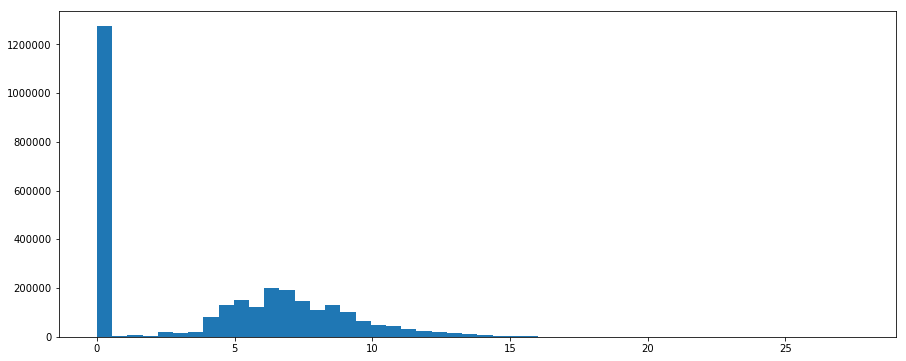

In [21]:
figure = plt.figure(figsize=(15,6))
plt.hist(x.price_diff, bins = 50)
plt.show()

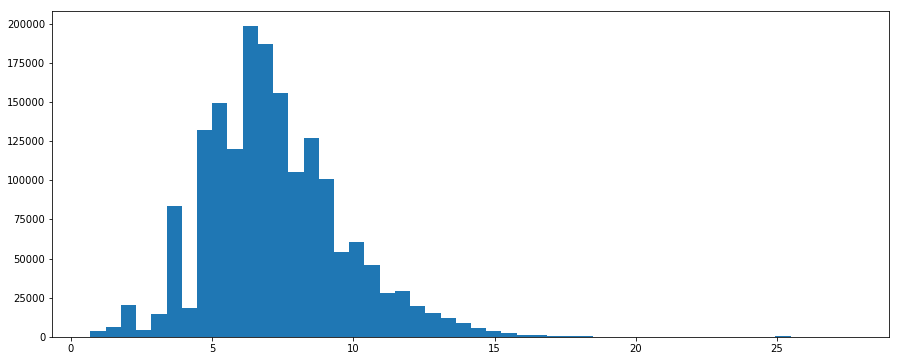

In [22]:
figure = plt.figure(figsize=(15,6))
plt.hist(np.array(x.price_diff)[np.where(x.price_diff != 0)], bins = 50)
plt.show()

## Images
Finding difference in number of images between the two items

In [23]:
x['images_array_x'] =  x['images_array_x'].apply(lambda s : len(s.split()) if isinstance(s, str) else 0)
x['images_array_y'] =  x['images_array_y'].apply(lambda s : len(s.split()) if isinstance(s, str) else 0)
x['images_num_diff'] = x[['images_array_x', 'images_array_y']].apply(lambda s: abs(s[0] - s[1]), axis = 1)

## Title and Description
Combine both columns and transform into document term matrix

In [24]:
x['title_x'] = x.title_x.map(lambda x : '' if pd.isnull(x) else x)
x['title_y'] = x.title_y.map(lambda x : '' if pd.isnull(x) else x)
x['description_x'] = x.description_x.map(lambda x : '' if pd.isnull(x) else x)
x['description_y'] = x.description_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_x'] = x_test.title_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_y'] = x_test.title_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_x'] = x_test.description_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_y'] = x_test.description_

x['title_desc_x'] = x.title_x + x.description_x
x['title_desc_y'] = x.title_y + x.description_y
#x_test['title_desc_x'] = x_test.title_x + x_test.description_x
#x_test['title_desc_y'] = x_test.title_y + x_test.description_y

x['title_desc_xy'] = x.title_desc_x + x.title_desc_y

In [ ]:
del x['itemID_1']
del x['itemID_2']
del x['itemID_x']
del x['itemID_y']
del x['categoryID_x']
del x['categoryID_y']
del x['parentCategoryID_y']
del x['images_array_x']
del x['images_array_y']
del x['attrsJSON_x']
del x['attrsJSON_y']
del x['price_x']
del x['price_y']
del x['locationID_x']
del x['locationID_y']
del x['metroID_x']
del x['metroID_y']
del x['lat_x']
del x['lat_y']
del x['lon_x']
del x['lon_y']
del x['regionID_x']
del x['regionID_y']
#del x['same_cat']
del x['generationMethod']
del x['title_x']
del x['title_y']
del x['description_x']
del x['description_y']

In [25]:
x.count()

itemID_1              2991396
itemID_2              2991396
isDuplicate           2991396
generationMethod      2991396
itemID_x              2991396
categoryID_x          2991396
title_x               2991396
description_x         2991396
images_array_x        2991396
attrsJSON_x           2885530
price_x               2707502
locationID_x          2991396
metroID_x             1015627
lat_x                 2991396
lon_x                 2991396
regionID_x            2991396
parentCategoryID_x    2991396
itemID_y              2991396
categoryID_y          2991396
title_y               2991396
description_y         2991396
images_array_y        2991396
attrsJSON_y           2885530
price_y               2707165
locationID_y          2991396
metroID_y             1015224
lat_y                 2991396
lon_y                 2991396
regionID_y            2991396
parentCategoryID_y    2991396
price_diff            2991396
images_num_diff       2991396
title_desc_x          2991396
title_desc

## Average Feature Vectors

In [28]:
def clean_text(document):    
    # Removes punctuations
    document = document.translate(None, string.punctuation)
    
    # Change to lowercase
    document = document.lower()
    
    # Removes newline characters
    document = ' '.join(document.split('\n'))
    
    # Replace multiple spaces with one space
    document = ' '.join(document.split())
    #document = nlp(unicode(document))
    
    return document

In [71]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        word = word.decode('utf-8')
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [72]:
# Word2Vec
sentences_desc_x = []
sentences_desc_y = []
a = x.description_x[0:10]
b = x.description_y[0:10]
for i in range(len(a)):
    sentences_desc_x.append(clean_text(a[i]).decode('utf-8').split())
    sentences_desc_y.append(clean_text(b[i]).decode('utf-8').split())
model_desc_x = Word2Vec(sentences_desc_x, min_count = 1)
model_desc_y = Word2Vec(sentences_desc_y, min_count = 1)

In [114]:
# doc2vec
sentences_desc_x = []
sentences_desc_y = []
a = x.description_x[0:10]
b = x.description_y[0:10]
for i in range(len(a)):
    sentences_desc_x.append(TaggedDocument(clean_text(a[i]).decode('utf-8').split(), [i]))
    sentences_desc_y.append(TaggedDocument(clean_text(b[i]).decode('utf-8').split(), [i]))

In [150]:
# doc2vec
from sklearn.metrics.pairwise import cosine_similarity
model = Doc2Vec(sentences_desc_x)
i = 1
cosine_similarity(np.array([model.infer_vector(clean_text(a[i]).decode('utf-8')), model.infer_vector(clean_text(b[i]).decode('utf-8'))]))


array([[ 1.        ,  0.17988287],
       [ 0.17988287,  1.        ]], dtype=float32)

In [143]:
print x.description_x[0:10]
print x.description_y[0:10]

0                            Продам Камаз 6520 20 тонн
1                                      Весь в тюнинге.
2    Телефон в хорошем состоянии, трещин и сколов н...
3    Отличный подарок на новый год от "китайской ap...
4        Лыжные ботинки в хорошем состоянии, 34 размер
5    сноубордические ботинки Nitro Team\nразмер 42,...
6    Машина новая пробег реальный. Не битая не краш...
7    Машина новая пробег реальный. Не битая не краш...
8    Телевизоры кинескопные, диагональ от 37 см. до...
9    качественная, производство Казань, хорошее сос...
Name: description_x, dtype: object
0                            Продам Камаз 6520 20 тонн
1                        Весь в тюнинге. Возможен торг
2    В отличном состоянии, в комплекте зарядник и к...
3    Отличный подарок на новый год от "китайской ap...
4               Ботинки 34 размер, в хорошем состоянии
5    ботинки Nitro Team\nразмер 42,5\n28см, 10 us\n...
6    Машина как новая. Комплектация максимальная- п...
7    Машина в идеальном состоя

In [148]:
# word2vec
for i in range(len(x.description_x[0:10])):
    print cosine_similarity(np.array([makeFeatureVec(clean_text(x.description_x[i]).split(), model_desc_x, num_features), makeFeatureVec(clean_text(x.description_y[i]).split(), model_desc_y, num_features)]))
    print x.isDuplicate[i]
    print
    


[[ 1.00000012  0.99995601]
 [ 0.99995601  1.00000012]]
1

[[ 0.99999988  0.79194969]
 [ 0.79194969  1.        ]]
1

[[ 1.          0.32071996]
 [ 0.32071996  1.        ]]
0

[[ 1.00000012  0.98104072]
 [ 0.98104072  0.99999994]]
1

[[ 1.          0.72722059]
 [ 0.72722059  1.00000012]]
1

[[ 0.99999994  0.96389675]
 [ 0.96389675  0.99999994]]
1

[[ 0.99999994  0.16203365]
 [ 0.16203365  0.99999988]]
0

[[ 0.99999994  0.21790418]
 [ 0.21790418  1.        ]]
0

[[ 1.          0.05282536]
 [ 0.05282536  1.00000012]]
0

[[ 0.99999988  0.45334521]
 [ 0.45334521  1.00000012]]
0



In [80]:
# word2vec subtraction
num_features = model_desc_x.wv.syn0.shape[1]
feature_vecs_desc = []
for i in range(len(x.description_x[0:10])):
    feature_vecs_desc.append(np.subtract(makeFeatureVec(clean_text(x.description_x[i]).split(), model_desc_x, num_features), makeFeatureVec(clean_text(x.description_y[i]).split(), model_desc_y, num_features)))
    #feature_vecs_desc_x.append(makeFeatureVec(clean_text(x.description_x[i]).split(), model_desc_x, num_features))
    #feature_vecs_desc_y.append(makeFeatureVec(clean_text(x.description_y[i]).split(), model_desc_y, num_features))
    #x.description_x[0:10].map(lambda x : makeFeatureVec(clean_text(x), model, num_features))

In [92]:
x_new = pd.concat((x[0:10], pd.DataFrame(feature_vecs_desc)), axis = 1)
y_new = x[0:10].isDuplicate

In [97]:
del x_new['itemID_2']
del x_new['itemID_x']
del x_new['itemID_y']
del x_new['categoryID_x']
del x_new['categoryID_y']
del x_new['parentCategoryID_y']
del x_new['images_array_x']
del x_new['images_array_y']
del x_new['attrsJSON_x']
del x_new['attrsJSON_y']
del x_new['price_x']
del x_new['price_y']
del x_new['locationID_x']
del x_new['locationID_y']
del x_new['metroID_x']
del x_new['metroID_y']
del x_new['lat_x']
del x_new['lat_y']
del x_new['lon_x']
del x_new['lon_y']
del x_new['regionID_x']
del x_new['regionID_y']
#del x['same_cat']
del x_new['generationMethod']
del x_new['title_x']
del x_new['title_y']
del x_new['description_x']
del x_new['description_y']
x_new.count()

isDuplicate           10
parentCategoryID_x    10
price_diff            10
images_num_diff       10
title_desc_x          10
title_desc_y          10
title_desc_xy         10
0                     10
1                     10
2                     10
3                     10
4                     10
5                     10
6                     10
7                     10
8                     10
9                     10
10                    10
11                    10
12                    10
13                    10
14                    10
15                    10
16                    10
17                    10
18                    10
19                    10
20                    10
21                    10
22                    10
                      ..
70                    10
71                    10
72                    10
73                    10
74                    10
75                    10
76                    10
77                    10
78                    10


In [98]:
del x_new['title_desc_x']
del x_new['title_desc_y']
del x_new['title_desc_xy']
x_new.count()

isDuplicate           10
parentCategoryID_x    10
price_diff            10
images_num_diff       10
0                     10
1                     10
2                     10
3                     10
4                     10
5                     10
6                     10
7                     10
8                     10
9                     10
10                    10
11                    10
12                    10
13                    10
14                    10
15                    10
16                    10
17                    10
18                    10
19                    10
20                    10
21                    10
22                    10
23                    10
24                    10
25                    10
                      ..
70                    10
71                    10
72                    10
73                    10
74                    10
75                    10
76                    10
77                    10
78                    10


In [99]:
x_new

,isDuplicate,parentCategoryID_x,price_diff,images_num_diff,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,1,1,0.000000,1,-0.000009,-0.000006,0.000014,-0.000016,-0.000010,0.000019,...,0.000020,-0.000019,0.000008,0.000010,-0.000034,0.000007,-1.140172e-05,0.000027,0.000024,0.000006
1,1,1,10.308953,1,0.000114,0.000765,-0.000597,-0.000714,-0.001065,-0.000524,...,-0.000362,-0.000312,-0.001814,0.001225,-0.002049,0.002724,4.035157e-04,0.000112,0.000489,-0.000863
2,0,6,0.000000,1,-0.001298,0.000708,-0.000822,0.000334,0.000629,0.000210,...,-0.000161,-0.001606,0.000681,0.001357,-0.000955,-0.000480,-5.875535e-04,0.000354,0.000653,-0.001375
3,1,6,0.000000,1,-0.000033,-0.000087,0.000079,-0.000043,0.000019,-0.000011,...,0.000044,-0.000036,-0.000045,0.000059,-0.000024,-0.000044,-7.976960e-07,0.000085,0.000055,0.000048
4,1,7,4.605170,0,-0.001105,0.000671,0.000015,0.001255,-0.000437,-0.000181,...,0.000188,0.000296,0.000463,-0.000276,-0.000348,0.000397,1.585739e-04,0.000396,0.001248,-0.000789
5,1,7,0.000000,0,-0.000011,-0.000423,0.000434,-0.000494,0.000133,-0.000123,...,0.000079,-0.000113,-0.000240,-0.000300,-0.000135,0.000593,3.142895e-04,0.000043,0.000399,-0.000455
6,0,1,8.517193,1,0.000829,-0.000255,0.000480,0.000146,-0.000931,-0.000061,...,0.000025,-0.001307,-0.000624,0.001665,0.000173,-0.001687,1.508246e-03,0.000034,0.000111,-0.000579
7,0,1,9.210340,3,-0.000539,-0.000148,0.000448,-0.000750,-0.001297,0.000025,...,0.000138,-0.002327,0.001110,0.000623,0.000220,-0.001716,1.562459e-03,0.001271,0.000647,0.001160
8,0,6,8.131531,0,-0.000488,-0.000982,0.001645,0.000943,-0.000120,0.000565,...,0.000939,0.002129,0.001036,0.000382,-0.001418,0.000698,-3.128113e-04,0.001596,0.001064,0.001361
9,0,5,8.779557,0,0.000182,-0.000197,-0.000913,-0.000077,0.000948,0.000117,...,-0.000421,-0.000714,-0.000719,-0.000326,-0.000103,0.001467,-1.132724e-03,0.000334,0.001669,0.000179


In [103]:
log_reg = LogisticRegression()
log_reg.fit(x_new.iloc[:, x_new.columns != 'isDuplicate'], x_new.isDuplicate)
print log_reg.predict(x_new.iloc[:, x_new.columns != 'isDuplicate'])
print x_new.isDuplicate

[1 0 1 1 1 1 0 0 0 0]
0    1
1    1
2    0
3    1
4    1
5    1
6    0
7    0
8    0
9    0
Name: isDuplicate, dtype: int64


In [178]:
class parCatIDTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return pd.DataFrame(X.parentCategoryID_x)

    def fit(self, X, y=None, **fit_params):
        return self
    
class priceDiffTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return pd.DataFrame(X.price_diff, columns = ['price_diff'])

    def fit(self, X, y=None, **fit_params):
        return self
    
class ContentTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return X.title_desc_xy

    def fit(self, X, y=None, **fit_params):
        return self
    
class featureVecTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return pd.DataFrame(X.feature, columns = ['feature'])

    def fit(self, X, y=None, **fit_params):
        return self

In [166]:
count_vect = CountVectorizer()
log_reg = LogisticRegression()

In [186]:
pipe_log = Pipeline([
    ('features', FeatureUnion([
        ('price_diff', priceDiffTransformer()), 
        ('parentCategoryID_x', parCatIDTransformer()),
        ('feature_vec', featureVecTransformer())
    ])),
    ('log_reg', log_reg)])

K-Fold CV to check validation and train accuracy

In [187]:
pipe_log.fit(new_x.iloc[:, new_x.columns != 'isDuplicate'], new_x.isDuplicate)

ValueError: setting an array element with a sequence.

In [172]:
kf = KFold(n_splits = 5, random_state = 1)
train_score = []
test_score = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.loc[train_index, :], x.loc[test_index, :]
    pipe_log.fit(x_train.iloc[:, x_train.columns != 'isDuplicate'], x_train.isDuplicate)
    pred_train = pipe_log.predict(x_train)
    pred_test = pipe_log.predict(x_test)
    train_score.append(pred_train)
    test_score.append(pred_test)
    print "Test Accuracy:", accuracy_score(x_test.isDuplicate, pred_test)
    print "Train Accuracy:", accuracy_score(x_train.isDuplicate, pred_train)

AttributeError: 'DataFrame' object has no attribute 'feature'

In [173]:
pipe_log.fit(new_x.iloc[:, new_x.columns != 'isDuplicate'], new_x.isDuplicate)

ValueError: all the input arrays must have same number of dimensions

In [170]:
new_x.isDuplicate

0    1
1    1
2    0
3    1
4    1
5    1
6    0
7    0
8    0
9    0
Name: isDuplicate, dtype: int64